# Final Project - Detecting Fraudulent Credit Card Transactions

| Course | Term | Section | Group | Objective | Kaggle URL |
| --- | --- | --- | --- | --- | --- |
| W207 | Fall 2022 | 11 | 2 | Detect fraudulent credit card transactions | IEEE-CIS Fraud Detection ([Link](kaggle.com/competitions/ieee-fraud-detection)) |

**Group Members**
- Naikaj Pandya
- Chase Madson
- Eric Danforth


# I. Setup

## A. Load Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# For splitting data 
from sklearn.model_selection import train_test_split

# For preprocessing
from sklearn.preprocessing import minmax_scale, OneHotEncoder

# For fitting
import tensorflow as tf

# For model evalutaion
from sklearn.metrics import roc_curve, auc

## B. Load Data

In [2]:
# Load Data
train = pd.read_csv('data/train_transaction.csv')
test = pd.read_csv('data/test_transaction.csv')
sub = pd.read_csv('data/sample_submission.csv').drop('isFraud', axis=1)

## C. Group the Columns

In [3]:
# Transaction payment amount in USD
features_num_amt = train[['TransactionAmt']].columns

# Date and time of transactions
features_num_dt = train.filter(regex='^txn').columns

# Distance measures between two masked points
features_num_dist = train.filter(regex='^dist').columns

# Various (masked) counts, e.g. how many addresses associated with payment card
features_num_C = train.filter(regex='^C').columns

# Various (masked) timedeltas, e.g. days between previous transactions
features_num_D = train.filter(regex='^D').columns

# Various (masked) Vesta engineered rich features
features_num_V = train.filter(regex='^V').columns

features_num = (
    features_num_amt
    .union(features_num_dt)
    .union(features_num_dist)
    .union(features_num_C)
    .union(features_num_D)
    .union(features_num_V)
)

In [4]:
# Product code for the product associated with the transaction
features_cat_CD = train[['ProductCD']].columns

# Payment card information, such as card type, card category, issue bank, country
# features_cat_card = train.filter(regex='^card').columns
features_cat_card4 = train.filter(regex='^card4').columns
features_cat_card6 = train.filter(regex='^card6').columns

# Address (unspecified)
features_cat_addr = train.filter(regex='^addr').columns

# Purchaser and recipient email domains
# features_cat_domain = train.filter(regex='domain$').columns

# Various matches (masked), e.g. names on card and addresses
features_cat_M = train.filter(regex='^M').columns

features_cat = (
    features_cat_CD
    # .union(features_cat_card)
    .union(features_cat_card4)
    .union(features_cat_card6)
    .union(features_cat_addr)
    # .union(features_cat_domain)
    .union(features_cat_M)
)

In [5]:
# Define the sets of features used, by variable type 
features = features_num.union(features_cat)

# Define our ID column and target
id = train[['TransactionID']].columns
target = train[['isFraud']].columns

# Select relevant columns
train = train[target.union(features)]
test = test[features]

print(f'We start with {len(features)} available features: {len(features_num)} numeric and {len(features_cat)} categorical.')

We start with 385 available features: 371 numeric and 14 categorical.


# II. Data Preparation

## Feature Engineering: Time of Transaction

## A. Split Data into Train and Validation

In [6]:
# Save 30% of the training data for validation
training, validation = train_test_split(train, test_size=0.3, random_state=1)

# With the remaining 70% in the training set, downsample the majority class
training = (
    training
    .groupby('isFraud')
    .sample(
        n=sum(training.isFraud == 1),
        random_state=1
    )
)

# Separate the features from the label
y_train = training[['isFraud']]
y_val = validation[['isFraud']]
X_train = training[features]
X_val = validation[features]

# Drop unneeded DataFrames
del training, validation

## B. Preprocessing Numeric Values

Apply Min-Max normalization and replace missing values for all numeric features in training, validation, and test sets

In [7]:
def replace_na_and_normalize(df, cols=features_num):
    return (df[cols]
        .apply(lambda var: var.fillna(var.min() - 2))
        .apply(minmax_scale, feature_range=(0,1))
    )

X_train[features_num] = replace_na_and_normalize(X_train)
X_val[features_num] = replace_na_and_normalize(X_val)
test[features_num] = replace_na_and_normalize(test)

## C. Preprocessing Categorical Values

Replace raw categorical features with one-hot encoding values

In [8]:
def get_one_hot_encoding(df, feature):
    # Instantiate the transformer
    ohe = OneHotEncoder()

    # Stack all datasets to get all unique categories observed
    categories = pd.concat([train[[feature]], test[[feature]]])

    # Fit the transformer with the observed classes
    ohe.fit(categories)

    # Create a sparse array with one binary vector per category
    transformed_array = ohe.transform(df[[feature]]).toarray()

    # Turn the transformed array into a DataFrame and assign names
    transformed_ndarray = pd.DataFrame(
        transformed_array,
        columns=ohe.get_feature_names_out(),
        index=df.index
    ).astype(np.float16)

    return transformed_ndarray

In [9]:
def replace_raw_cats_with_one_hots(df, cols=features_cat):
    # Initialize a placeholder list
    tmp_list = []

    # For each variable in our categorical features, get one-hot encoding matrix
    for var in features_cat:
        tmp_list.append(get_one_hot_encoding(df, var))

    # Convert list of DataFrames into one DataFrame of several sparse matrices
    tmp_df = pd.concat(tmp_list, axis=1)

    # Drop the raw categorical variables and replace with sparce matrices
    new_df = pd.concat([df.drop(features_cat, axis=1), tmp_df], axis=1)
    
    return new_df

In [10]:
# Carry out the one-hot encoding functions above for each data set
X_train = replace_raw_cats_with_one_hots(X_train)
X_val = replace_raw_cats_with_one_hots(X_val)
test = replace_raw_cats_with_one_hots(test)

# III. Fitting a Model

In [11]:
def build_model(
  n_classes=1,
  hidden_layer_sizes=[],
  activation='relu',
  optimizer='adam',
  learning_rate=0.01
  ):
  """Build a logistic regression model using Keras.

  Args:
    n_classes: Number of output classes in the dataset.
    hidden_layer_sizes: A list with the number of units in each hidden layer.
    activation: The activation function to use for the hidden layers.
    optimizer: The optimizer to use (SGD, Adam).
    learning_rate: The desired learning rate for the optimizer.

  Returns:
    model: A tf.keras model (graph).
  """
  
  # HOUSEKEEPING
  ## Reset any nodes from prior tf session
  tf.keras.backend.clear_session()
  ## Fix seed of SGD
  np.random.seed(0)
  tf.random.set_seed(0)

  # INPUT LAYER
  ## Instantiate a model with Sequantial
  model = tf.keras.Sequential()
  
  # HIDDEN LAYERS
  for hidden_layer_size in hidden_layer_sizes:
    model.add(
      tf.keras.layers.Dense(units=hidden_layer_size, activation=activation)
      )

  # OUTPUT LAYER
  # Add step to calculate weights for each input feature
  model.add(tf.keras.layers.Dense(
    units=n_classes,     # Dim of output space
    use_bias=True,       # Specify to keep bias term
    activation='sigmoid' # Apply sigmoid function since its binary classification
    ))

  # Instantiate optimizer object based on string value
  optimizer = tf.keras.optimizers.get(optimizer, learning_rate=learning_rate)
 
  # Specify the loss function
  model.compile(
    loss='binary_crossentropy', 
    optimizer=optimizer, 
    metrics=['accuracy']
  )

  return model

In [12]:
def train_and_evaluate(
  df_x_train=X_train,
  df_y_train=y_train,
  df_x_test=X_val,
  df_y_test=y_val,
  hidden_layer_sizes=[],
  activation='tanh',
  optimizer='Adam',
  learning_rate=0.01,
  num_epochs=5
  ):

  # Build the model.
  model = build_model(
    n_classes=1,
    hidden_layer_sizes=hidden_layer_sizes,
    activation=activation,
    optimizer=optimizer,
    learning_rate=learning_rate
    )

  # Train the model.
  print('Training...')

  history = model.fit(
    x=df_x_train,
    y=df_y_train,
    epochs=num_epochs,
    batch_size=64,
    validation_split=0.1,
    verbose=1
    )
    
  # Retrieve training metrics (after each train epoch) and the final test accuracy
  train_accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']
  plt.plot(train_accuracy, label='train_accuracy')
  plt.plot(val_accuracy, label='validation accuracy')
  plt.xticks(range(num_epochs))
  plt.xlabel('Train epochs')
  plt.legend()
  plt.show()

  test_accuracy = model.evaluate(
    x=df_x_test,
    y=df_y_test,
    verbose=0,
    return_dict=True
    )['accuracy']
    
  return model

Training...
Epoch 1/16
409/409 [==============================] - 2s 4ms/step - loss: 0.5770 - accuracy: 0.6944 - val_loss: 0.7358 - val_accuracy: 0.5472
Epoch 2/16
409/409 [==============================] - 1s 3ms/step - loss: 0.5475 - accuracy: 0.7216 - val_loss: 0.5996 - val_accuracy: 0.6870
Epoch 3/16
409/409 [==============================] - 1s 3ms/step - loss: 0.5376 - accuracy: 0.7327 - val_loss: 0.4529 - val_accuracy: 0.8120
Epoch 4/16
409/409 [==============================] - 1s 3ms/step - loss: 0.5305 - accuracy: 0.7375 - val_loss: 0.5058 - val_accuracy: 0.7755
Epoch 5/16
409/409 [==============================] - 1s 3ms/step - loss: 0.5230 - accuracy: 0.7458 - val_loss: 0.6046 - val_accuracy: 0.6963
Epoch 6/16
409/409 [==============================] - 1s 3ms/step - loss: 0.5183 - accuracy: 0.7436 - val_loss: 0.5443 - val_accuracy: 0.7273
Epoch 7/16
409/409 [==============================] - 1s 3ms/step - loss: 0.5133 - accuracy: 0.7470 - val_loss: 0.3283 - val_accuracy: 0

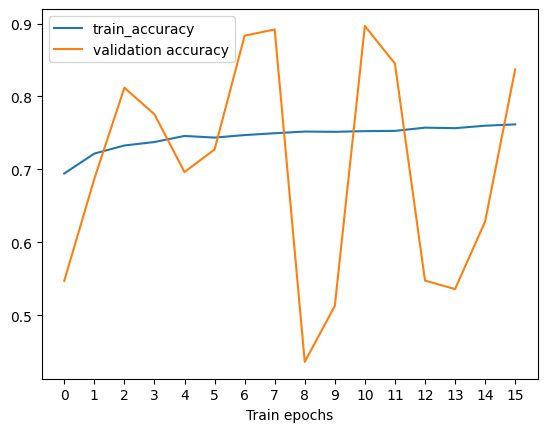

In [13]:
fit = train_and_evaluate(
    hidden_layer_sizes=[512, 256, 128, 64],
    optimizer='SGD',
    learning_rate=0.001,
    num_epochs=16
)

# IV. Evaluating the Model

5537/5537 [==============================] - 7s 1ms/step


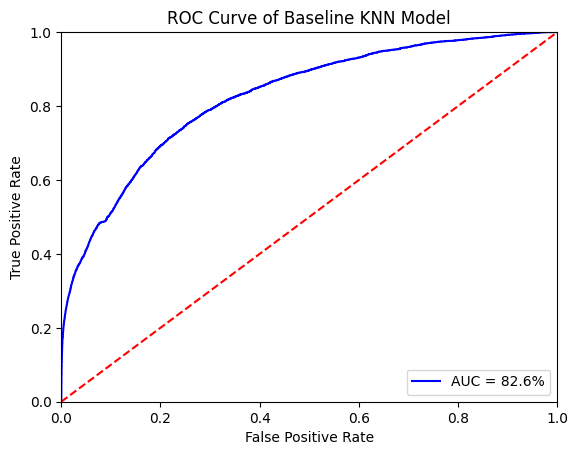

In [14]:
fpr, tpr, threshold = roc_curve(y_val, fit.predict(X_val))
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, 'b', label = f'AUC = {roc_auc:.1%}')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of Baseline KNN Model')
plt.show()

# V. Outputting Model

In [15]:
# sub['isFraud'] = fit.predict(test)
# sub.to_csv('data/submissions/nn_baseline.csv', index=False)